In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
BATCH_SIZE = 256
IMG_SIZE = 224
NUM_EPOCHS = 10

# Data augmentation and preprocessing
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.14, 0.14)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='datasets/datasets/train',
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root='datasets/datasets/val',
    transform=val_transform
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

class VGG16Model(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16Model, self).__init__()
        # Load pretrained VGG16
        self.vgg16 = models.vgg16(pretrained=True)
        
        # Freeze VGG16 layers
        for param in self.vgg16.parameters():
            param.requires_grad = False
            
        # Remove original classifier
        self.features = self.vgg16.features
        
        # Create new classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(512 * 7 * 7),
            nn.Linear(512 * 7 * 7, 256),
            nn.Softplus(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            
            nn.Linear(256, 256),
            nn.Softplus(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            
            nn.Linear(256, 256),
            nn.Softplus(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            
            nn.Linear(256, 256),
            nn.Softplus(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def plot_training_history(train_losses, val_losses, train_accs, val_accs, title=''):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    
    # Loss plot
    ax[0].plot(train_losses, label='Training Loss')
    ax[0].plot(val_losses, label='Validation Loss')
    ax[0].legend(loc='upper right')
    ax[0].set_title(title + ' Loss')
    
    # Accuracy plot
    ax[1].plot(train_accs, label='Training Accuracy')
    ax[1].plot(val_accs, label='Validation Accuracy')
    ax[1].legend(loc='lower right')
    ax[1].set_title(title + ' Accuracy')
    
    plt.show()

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'fine_tuning.pth')
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 50)
        
    return train_losses, val_losses, train_accs, val_accs

def main():
    # Create model
    model = VGG16Model().to(device)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    # Train model
    history = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)
    
    # Plot training history
    plot_training_history(*history)
    
    # Load best model
    model.load_state_dict(torch.load('fine_tuning.pth'))
    return model


In [3]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 29.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


/home/george_1/miniconda3/envs/ai_project/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/george_1/miniconda3/envs/ai_project/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 0.3600 | Train Acc: 95.33%
Val Loss: 0.3279 | Val Acc: 98.42%
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.3435 | Train Acc: 96.92%
Val Loss: 0.3291 | Val Acc: 98.42%
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.3435 | Train Acc: 96.91%
Val Loss: 0.3286 | Val Acc: 98.38%
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.3405 | Train Acc: 97.11%
Val Loss: 0.3266 | Val Acc: 98.62%
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.3422 | Train Acc: 97.09%
Val Loss: 0.3274 | Val Acc: 98.58%
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.3398 | Train Acc: 97.22%
Val Loss: 0.3282 | Val Acc: 98.36%
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.3400 | Train Acc: 97.25%
Val Loss: 0.3261 | Val Acc: 98.66%
--------------------------------------------------
Epoch 8/10:
Train Loss: 0.3386 | Train Ac

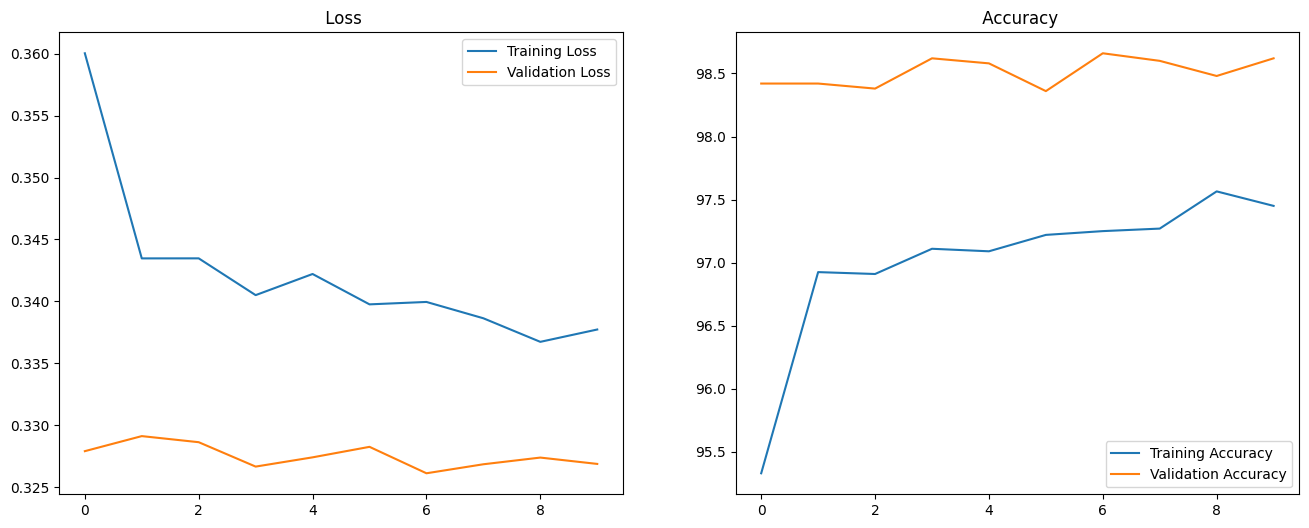

/tmp/ipykernel_233736/914430651.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fine_tuning.pth'))


In [5]:
if __name__ == '__main__':
    model = main()